In [1]:
SEED = 123      # modifiable seed
CLF_SS = 2      # sub-sample model types for faster run
TARGETS = -1    # which target (0-4) to predict; -1 for all

In [2]:
import os
import os.path as pth
from itertools import product, combinations

import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import pearsonr
import nilearn as nl
import nibabel as nib
import h5py
import pandas as pd
from multiprocessing import Pool
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, \
                                    GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import class_weight

import json
import shutil

import gc

from numba import jit, njit

# from tpot import TPOTRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [4]:
import numpy as np  
import pandas as pd 
import pickle

In [5]:
import multiprocessing
from joblib import Parallel, delayed

In [6]:
from collections import Counter
import datetime as datetime

In [7]:
import gc
import psutil
import sys

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (15,5.5)

pd.options.display.max_rows = 150

In [9]:
start = datetime.datetime.now()

if SEED < 0:
    np.random.seed(datetime.datetime.now().microsecond)
else:
    np.random.seed(SEED)

In [10]:
BASE_PATH = pth.join('/users/lww/data/trend_competition')
os.listdir(BASE_PATH)

['fMRI_mask.nii',
 'fMRI_test',
 'fMRI_train',
 'fnc.csv',
 'ICN_numbers.csv',
 'loading.csv',
 'reveal_ID_site2.csv',
 'sample_submission.csv',
 'train_scores.csv',
 'model',
 'ttest',
 'two_sample_ttest',
 'average_GICA',
 'transposed_GICA',
 'average_zscore_GICA',
 'average_minmax_GICA']

In [11]:
loading =  pd.read_csv(BASE_PATH+ '/' + 'loading.csv').set_index('Id')
fnc =  pd.read_csv(BASE_PATH+ '/' + 'fnc.csv').set_index('Id')
assert len(loading) == len(fnc)

In [12]:
excluded_features = ['IC_20']
# excluded_features = ['IC_02', 'IC_20']
loading_strs = [feature_str for feature_str in loading.columns if feature_str not in excluded_features]
loading_strs = np.array(loading_strs)
fnc_strs = np.array(fnc.columns)
len(loading_strs), loading_strs

(25, array(['IC_01', 'IC_07', 'IC_05', 'IC_16', 'IC_26', 'IC_06', 'IC_10',
        'IC_09', 'IC_18', 'IC_04', 'IC_12', 'IC_24', 'IC_15', 'IC_13',
        'IC_17', 'IC_02', 'IC_08', 'IC_03', 'IC_21', 'IC_28', 'IC_11',
        'IC_30', 'IC_22', 'IC_29', 'IC_14'], dtype='<U5'))

In [13]:
remained_loading_features = np.load('selected_features/ttest_tr-vs-ts_000001_lf_features.npy', allow_pickle=True)
remained_fnc_features = np.load('selected_features/ttest_tr-vs-ts_0001_fnc_features.npy', allow_pickle=True)

In [14]:
univariate_important_features = np.load('selected_features/univariate_important_features.npy', allow_pickle=True)
lgbm_importance_features = np.load('selected_features/lgbm_importance_features.npy', allow_pickle=True)
tfe_ridge_important_reverse_features = np.load('selected_features/tfe_ridge_important_reverse_features.npy', allow_pickle=True)

In [15]:
y_data =  pd.read_csv(BASE_PATH+ '/' + 'train_scores.csv').set_index('Id')

data = pd.concat((loading[loading_strs], fnc,  ), axis = 'columns')  
test_data = data[~data.index.isin(y_data.index)]

X = data.loc[y_data.index] 
y = y_data 
groups = np.random.randint(0, 5, len(y))

In [16]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, KFold, ShuffleSplit
from sklearn.svm import SVR, NuSVR
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, FunctionTransformer 

In [17]:
nusvr_params = {
    'kernel': [  'rbf',  ] , 
    'C': [ 1, 2, 3, 5, 7, 10, 15, 20, 30, 50, 70, 100, 130, 200  ],
    'gamma': [ 'scale'], 
    'nu': [   0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1] }

def trainNuSVR(x, y, groups, cv = 0, n_jobs = -1, **kwargs):
    clf = NuSVR(cache_size=1000)
    params = nusvr_params        
    return trainModel(x, y, groups, clf, params, cv, n_jobs,  **kwargs)

In [18]:
enet_params = { 'alpha': [  1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 3e-2, 0.1, 0.3,   ],
                'l1_ratio': [ 0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.95, 0.97, 0.98, 0.99, 1,   ]}

def trainENet(x, y, groups, cv = 0, n_jobs = -1, **kwargs):
    clf = ElasticNet(normalize = True, selection = 'random', max_iter = 1000 )
    return trainModel(x, y, groups, clf, enet_params, cv, n_jobs, **kwargs)

In [19]:
def fnae(y_true, y_pred):
    valid = ~np.isnan(y_true)
    y_true = y_true[valid]
    y_pred = y_pred[valid]
    return np.sum(np.abs(y_true - y_pred))/np.sum(y_true)

fnae_scorer = make_scorer(fnae, greater_is_better = False)

In [20]:
def trainModel(x, y, groups, clf, params, cv = 0, n_jobs = None, 
                   verbose=0, splits=None, **kwargs):
    if n_jobs is None:
        n_jobs = -1    

    n_iter = 30
        
    folds = ShuffleSplit(n_splits = 10, train_size = 0.75, test_size = 0.20)
    clf = RandomizedSearchCV(clf, params, cv = folds, n_iter = n_iter, 
                            verbose = 1, n_jobs = n_jobs, scoring = fnae_scorer)
    
    f = clf.fit(x, y, groups)
    
    print(pd.DataFrame(clf.cv_results_['mean_test_score'])); print();  
    best = clf.best_estimator_;  print(best)
    print("Best Score: {}".format(np.round(clf.best_score_,4)))
    
    return best

In [21]:
def cleanX(X, target):
    X = X.copy()
    
    for col in list(set(X.columns) & set(fnc.columns)):
        X[col] = X[col] / 600
       
    return X;

In [22]:
def runBag(n = 3, model_type = trainENet, data = None, **kwargs):
    start_time = datetime.datetime.now(); 
    
    X, y, groups = data

    valid = ~y.isnull()
    X = X[valid]; y = y[valid]; groups = groups[valid]
    
    if 'target' in kwargs:
        X = cleanX(X, kwargs['target'])
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()
    
    clfs = []; preds = []; ys=[]; datestack = []
    for group in group_list:
        g = gc.collect()
        x_holdout = X[groups == group]
        y_holdout = y[groups == group]
        x_train = X[groups != group]
        y_train = y[groups != group]
        
        groups_train = groups[groups != group]

        model = model_type 
        clf = model(x_train, y_train, groups_train, **kwargs) 
        clfs.append(clf)

        predicted = clf.predict(x_holdout)
        print("{}: {:.4f}".format(group,
              fnae(y_holdout, predicted)  ) )
        
        preds.append(predicted)
        ys.append(y_holdout)
    
    y_pred = np.concatenate(preds)
    y_ho = np.concatenate(ys) 

    end_time = datetime.datetime.now(); 
    print("\nModel Bag Time: {}\n".format(str(end_time - start_time).split('.', 2)[0] ))
    return clfs

In [23]:
def trainBaseClfs(clfs, clf_names, data, target = None, **kwargs):
    start_time = datetime.datetime.now(); 
    
    X, y, groups = data
    
    X = cleanX(X, target)
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()
    
    X_ordered = []; y_ordered = []; groups_ordered =[]  
    all_base_clfs = []; base_preds = [[] for i in range(0, 5 * len(clfs))]; 
    for group in group_list:
        print("Training Fold {} of {}:".format(group, len(group_list)))
        np.random.seed(SEED)
        
        x_holdout = X[groups == group]
        y_holdout = y[groups == group]
        x_train = X[groups != group]
        y_train = y[groups != group]

        y_idx = ALL_TARGETS.index(target)
        
        X_ordered.append(x_holdout)
        y_ordered.append(y_holdout)
        groups_ordered.append(groups[groups == group])
        
        base_clfs = []
        for idx, clf in enumerate(clfs):
            base_clfs.append(clone(clf))
        
        def train_model(model, X, y):
            ss = (~pd.DataFrame(y).isnull().any(axis=1))
            model.fit(X[ss], y[ss]); return model
        
        base_clfs = Parallel(n_jobs=4)(delayed(train_model)(model, x_train, y_train[y_var]) for model in base_clfs)
        all_base_clfs.append(base_clfs)
        
        def predict_model(model, X):
            o = model.predict(X); return o    
        preds = Parallel(n_jobs=4)(delayed(predict_model)(model, x_holdout) for model in base_clfs)
        
        
        pidx = 0; clf_pred_names = []
        for idx, clf in enumerate(base_clfs):   
            print("{:.4f} for {}".format( 
                      fnae(y_holdout[target], preds[idx]), clf_names[idx]  ) )
            base_preds[pidx].append(preds[idx]); pidx+=1;
            clf_pred_names.append(clf_names[idx])
            
        print("\nTime Elapsed: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))

    base_preds = base_preds[:len(clf_pred_names)]
    for idx in range(0, len(base_preds)):
        base_preds[idx] = np.concatenate(base_preds[idx])

    
    print("\Base Classifier Train Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    return (all_base_clfs, base_preds, clf_pred_names, 
        pd.concat(X_ordered), pd.concat(y_ordered), np.concatenate(groups_ordered))

In [24]:
def Lassos():
    clfs = []; clf_names = []
    lassos =  [1e-5, 3e-5, 1e-4,  3e-4,  0.001, 0.003,  0.01,  0.03,  0.1,  0.3,  1, ]
    for l in lassos:
        clfs.append(Lasso(alpha = l,  selection = 'random', max_iter = 1000))
        clf_names.append('Lasso alpha={}'.format(l))
        if CLF_SS > 1:
            clfs.append(clfs[-1]); clf_names.append(clf_names[-1])
 
    return clfs, clf_names

In [25]:
def Ridges():
    clfs = []; clf_names = []
    ridges =  [1e-4,  3e-4,  0.001, 0.003,  0.01,  0.03,  0.1,  0.3,  1,  3,  10,    ]
    for r in ridges:
        clfs.append(Ridge(alpha = r))
        clf_names.append('Ridge alpha={}'.format(r))
        if CLF_SS > 1:
            clfs.append(clfs[-1]); clf_names.append(clf_names[-1])

    return clfs, clf_names

In [26]:
def SVRs():
    clfs = []; clf_names = []
    svrs =  ([0.2, 1, 7, 50], [1, 3, 7]) 
    for c in svrs[0]:
        for e in svrs[1]:
            clfs.append(SVR(C = c, epsilon = e, cache_size=1000))
            clf_names.append('SVR C={}, epsilon={}'.format(c,e))
            
    return clfs, clf_names

In [27]:
def ENets():
    clfs = []; clf_names = []
    enets = ([1e-4, 3e-4, 1e-3, 3e-3  ], [ 0, 0.1, 0.5, 0.9, 0.95, 1]) 
    for a in enets[0]:
        for l in enets[1]:
            clfs.append(ElasticNet(alpha = a, l1_ratio = l,
                         normalize = False, selection = 'random', 
                         max_iter = 1000))
            clf_names.append('Enet alpha={}, l1_ratio={}'.format(a,l))
 
    for a in enets[0]:
        for l in enets[1]:
            clfs.append(ElasticNet(alpha = a, l1_ratio = l,
                         normalize = True, selection = 'random', 
                         max_iter = 1000 ))
            clf_names.append('Enet-n alpha={}, l1_ratio={}'.format(a,l))
            
    return clfs, clf_names

In [28]:
def getBaseClfs(y_var):
    idx = ALL_TARGETS.index(y_var)

    clfs = []
    clf_names = []
    
    model_sets =  [SVRs(), ENets(), Lassos(), Ridges()]
    for model_set in model_sets:
        clfs.extend(model_set[0])
        clf_names.extend(model_set[1])
   

    return clfs[::CLF_SS], clf_names[::CLF_SS];

In [29]:
ALL_TARGETS = y.columns.to_list()  
if isinstance(TARGETS, list):
    targets = [ALL_TARGETS[i] for i in TARGETS]
elif TARGETS is not None and TARGETS >= 0:
    targets = ALL_TARGETS[TARGETS: TARGETS + 1]
else:
    targets = ALL_TARGETS

In [30]:
def metaFilter(X):
    return X[[c for c in X.columns if c not in data.columns or c in loading.columns ]] 

In [31]:
all_clfs = []; all_raw_base_clfs = []; all_base_clfs = []; scalers = []
for idx, y_var in enumerate(targets):
    print('---Training Models for {}---\n'.format(y_var))
    
    univariate_ld_target_features = univariate_important_features[0][idx]
    univariate_ld_target_features = (univariate_ld_target_features > np.mean(univariate_ld_target_features))
    univariate_ld_target_features = loading_strs[univariate_ld_target_features]
    univariate_fnc_target_features = univariate_important_features[1][idx]
    univariate_fnc_target_features = (univariate_fnc_target_features > np.mean(univariate_fnc_target_features))
    univariate_fnc_target_features = fnc_strs[univariate_fnc_target_features]

    lgbm_ld_target_features = lgbm_importance_features[0][idx]
    lgbm_ld_target_features = (lgbm_ld_target_features > np.mean(lgbm_ld_target_features))
    lgbm_ld_target_features = loading_strs[lgbm_ld_target_features]
    lgbm_fnc_target_features = lgbm_importance_features[1][idx]
    lgbm_fnc_target_features = (lgbm_fnc_target_features > np.mean(lgbm_fnc_target_features))
    lgbm_fnc_target_features = fnc_strs[lgbm_fnc_target_features]

    ridge_ld_target_features = tfe_ridge_important_reverse_features[0][idx]
    ridge_ld_target_features = (ridge_ld_target_features > np.mean(ridge_ld_target_features))
    ridge_ld_target_features = loading_strs[ridge_ld_target_features]
    ridge_fnc_target_features = tfe_ridge_important_reverse_features[1][idx]
    ridge_fnc_target_features = (ridge_fnc_target_features > np.mean(ridge_fnc_target_features))
    ridge_fnc_target_features = fnc_strs[ridge_fnc_target_features]
    
    ld_target_features = list(
        (set(univariate_ld_target_features) | set(lgbm_ld_target_features) | set(ridge_ld_target_features)) 
            | set(remained_loading_features)
    )
    fnc_target_features = list(
        (set(univariate_fnc_target_features) | set(lgbm_fnc_target_features) | set(ridge_fnc_target_features)) 
            | set(remained_fnc_features)
    )
    
    target_features = ld_target_features + fnc_target_features
    print(len(ld_target_features), len(fnc_target_features))
    
    target_X = X[target_features]
       
    # train base classifiers
    raw_base_clfs, base_clf_names = getBaseClfs(y_var)
    all_raw_base_clfs.append((raw_base_clfs, base_clf_names))
    
    base_clfs, base_clf_preds, base_clf_names, Xe, ye, ge = \
                    trainBaseClfs(raw_base_clfs, base_clf_names, 
                                  data = (target_X, y, groups), 
                                  target=y_var, )
    Xe = pd.concat( (Xe, pd.DataFrame( dict(zip(base_clf_names, base_clf_preds)), index=Xe.index) ),
                     axis = 'columns')
    
    all_base_clfs.append((base_clfs, base_clf_preds, base_clf_names, Xe, ye, ge ))
    
    
    # train meta model
    s = FunctionTransformer()
    if y_var == 'age':
        meta_model = trainNuSVR
    else:
        meta_model = trainENet
     
    s.fit(metaFilter(Xe))
    scalers.append(s)
    
    all_clfs.append( runBag(data = (s.transform(metaFilter(Xe)), ye[y_var], ge), # target=y_var,
                                   model_type = meta_model) )

---Training Models for age---

24 1347
Training Fold 0 of 5:
0.1830 for SVR C=0.2, epsilon=1
0.1875 for SVR C=0.2, epsilon=7
0.1636 for SVR C=1, epsilon=3
0.1546 for SVR C=7, epsilon=1
0.1557 for SVR C=7, epsilon=7
0.1479 for SVR C=50, epsilon=3
0.1927 for Enet alpha=0.0001, l1_ratio=0
0.1812 for Enet alpha=0.0001, l1_ratio=0.5
0.1603 for Enet alpha=0.0001, l1_ratio=0.95
0.2092 for Enet alpha=0.0003, l1_ratio=0
0.1997 for Enet alpha=0.0003, l1_ratio=0.5
0.1675 for Enet alpha=0.0003, l1_ratio=0.95
0.2192 for Enet alpha=0.001, l1_ratio=0
0.2150 for Enet alpha=0.001, l1_ratio=0.5
0.1835 for Enet alpha=0.001, l1_ratio=0.95
0.2227 for Enet alpha=0.003, l1_ratio=0
0.2212 for Enet alpha=0.003, l1_ratio=0.5
0.2033 for Enet alpha=0.003, l1_ratio=0.95
0.1524 for Enet-n alpha=0.0001, l1_ratio=0
0.1503 for Enet-n alpha=0.0001, l1_ratio=0.5
0.1535 for Enet-n alpha=0.0001, l1_ratio=0.95
0.1607 for Enet-n alpha=0.0003, l1_ratio=0
0.1549 for Enet-n alpha=0.0003, l1_ratio=0.5
0.1495 for Enet-n alpha=0.

/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[1 1 1 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   59.3s finished


           0
0  -0.141480
1  -0.141021
2  -0.141209
3  -0.141991
4  -0.141831
5  -0.141239
6  -0.141098
7  -0.141464
8  -0.141199
9  -0.140954
10 -0.141842
11 -0.142320
12 -0.140905
13 -0.141059
14 -0.141394
15 -0.140979
16 -0.140997
17 -0.141269
18 -0.142228
19 -0.141110
20 -0.141558
21 -0.141690
22 -0.142283
23 -0.141190
24 -0.141314
25 -0.140975
26 -0.141898
27 -0.141002
28 -0.141408
29 -0.141603

NuSVR(C=130, cache_size=1000, nu=0.6)
Best Score: -0.1409
0: 0.1471
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   53.1s finished


           0
0  -0.142319
1  -0.142486
2  -0.142088
3  -0.142128
4  -0.142703
5  -0.142942
6  -0.142130
7  -0.142178
8  -0.142150
9  -0.143300
10 -0.142692
11 -0.143606
12 -0.143409
13 -0.142497
14 -0.143017
15 -0.142512
16 -0.142469
17 -0.142618
18 -0.142941
19 -0.142405
20 -0.142657
21 -0.142130
22 -0.141965
23 -0.143245
24 -0.142225
25 -0.142093
26 -0.143386
27 -0.142541
28 -0.142335
29 -0.143399

NuSVR(C=200, cache_size=1000, nu=0.4)
Best Score: -0.142
1: 0.1414
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.7s finished


           0
0  -0.140923
1  -0.140750
2  -0.140841
3  -0.140780
4  -0.142128
5  -0.140613
6  -0.141216
7  -0.141264
8  -0.140591
9  -0.140699
10 -0.141338
11 -0.140823
12 -0.140661
13 -0.140914
14 -0.141972
15 -0.140630
16 -0.142651
17 -0.140836
18 -0.140645
19 -0.141682
20 -0.140594
21 -0.140666
22 -0.140599
23 -0.140652
24 -0.141328
25 -0.141372
26 -0.140601
27 -0.140550
28 -0.140815
29 -0.140633

NuSVR(C=30, cache_size=1000, nu=0.4)
Best Score: -0.1405
2: 0.1429
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.5s finished


           0
0  -0.143857
1  -0.143887
2  -0.143837
3  -0.143493
4  -0.143548
5  -0.143565
6  -0.143583
7  -0.143813
8  -0.143874
9  -0.143812
10 -0.143623
11 -0.143849
12 -0.143816
13 -0.143868
14 -0.143983
15 -0.143720
16 -0.143924
17 -0.143734
18 -0.143606
19 -0.143822
20 -0.143455
21 -0.144074
22 -0.143948
23 -0.143585
24 -0.143885
25 -0.143556
26 -0.144052
27 -0.143427
28 -0.143814
29 -0.143875

NuSVR(C=200, cache_size=1000)
Best Score: -0.1434
3: 0.1384
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   53.0s finished


           0
0  -0.143366
1  -0.143589
2  -0.144299
3  -0.143053
4  -0.143532
5  -0.143779
6  -0.143522
7  -0.144127
8  -0.143242
9  -0.143447
10 -0.143141
11 -0.143393
12 -0.144139
13 -0.143662
14 -0.143123
15 -0.144471
16 -0.143186
17 -0.143751
18 -0.143482
19 -0.144532
20 -0.143106
21 -0.143210
22 -0.143171
23 -0.143586
24 -0.143300
25 -0.143642
26 -0.143974
27 -0.144027
28 -0.143083
29 -0.143368

NuSVR(C=200, cache_size=1000, nu=0.9)
Best Score: -0.1431
4: 0.1400

Model Bag Time: 0:04:44

---Training Models for domain1_var1---

24 1348
Training Fold 0 of 5:
0.1504 for SVR C=0.2, epsilon=1
0.1507 for SVR C=0.2, epsilon=7
0.1488 for SVR C=1, epsilon=3
0.1485 for SVR C=7, epsilon=1
0.1476 for SVR C=7, epsilon=7
0.1490 for SVR C=50, epsilon=3
0.1512 for Enet alpha=0.0001, l1_ratio=0
0.1501 for Enet alpha=0.0001, l1_ratio=0.5
0.1485 for Enet alpha=0.0001, l1_ratio=0.95
0.1530 for Enet alpha=0.0003, l1_ratio=0
0.1521 for Enet alpha=0.0003, l1_ratio=0.5
0.1491 for Enet alpha=0.0003, l1_ra

/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[1 1 1 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.7s finished


           0
0  -0.154081
1  -0.153302
2  -0.153082
3  -0.159688
4  -0.155282
5  -0.156279
6  -0.153175
7  -0.160307
8  -0.153323
9  -0.160036
10 -0.159720
11 -0.153827
12 -0.153044
13 -0.153231
14 -0.153109
15 -0.153054
16 -0.153338
17 -0.153285
18 -0.153342
19 -0.152973
20 -0.152967
21 -0.153343
22 -0.156305
23 -0.153067
24 -0.153093
25 -0.153320
26 -0.153328
27 -0.156148
28 -0.155864
29 -0.153267

ElasticNet(alpha=0.002, l1_ratio=0.4, normalize=True, selection='random')
Best Score: -0.153
0: 0.1468


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.1s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9178.08946617681, tolerance: 44.50840987562535
  positive)


           0
0  -0.148637
1  -0.152502
2  -0.148763
3  -0.148621
4  -0.148558
5  -0.148628
6  -0.148633
7  -0.148717
8  -0.148613
9  -0.152237
10 -0.148288
11 -0.148569
12 -0.148451
13 -0.148543
14 -0.148346
15 -0.148565
16 -0.152487
17 -0.147872
18 -0.152469
19 -0.155662
20 -0.148618
21 -0.148566
22 -0.148556
23 -0.148343
24 -0.148787
25 -0.148233
26 -0.149107
27 -0.150040
28 -0.154916
29 -0.148575

ElasticNet(alpha=5e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1479
1: 0.1558


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.2s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18257.48113779415, tolerance: 44.88377541520106
  positive)


           0
0  -0.151714
1  -0.151710
2  -0.151646
3  -0.151592
4  -0.153076
5  -0.151723
6  -0.151610
7  -0.159216
8  -0.152115
9  -0.151743
10 -0.151517
11 -0.151605
12 -0.159480
13 -0.151561
14 -0.154257
15 -0.159480
16 -0.158283
17 -0.151245
18 -0.151418
19 -0.151744
20 -0.152658
21 -0.151690
22 -0.151709
23 -0.157825
24 -0.151601
25 -0.159394
26 -0.152170
27 -0.151594
28 -0.151474
29 -0.151738

ElasticNet(alpha=2e-05, l1_ratio=0.98, normalize=True, selection='random')
Best Score: -0.1512
2: 0.1506


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.4s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77634.89008062723, tolerance: 44.71508193209533
  positive)


           0
0  -0.151396
1  -0.151565
2  -0.151394
3  -0.151658
4  -0.151691
5  -0.151416
6  -0.151397
7  -0.151465
8  -0.158070
9  -0.151485
10 -0.151376
11 -0.150795
12 -0.150590
13 -0.152204
14 -0.151192
15 -0.151460
16 -0.151498
17 -0.153984
18 -0.151393
19 -0.151379
20 -0.151127
21 -0.155137
22 -0.151419
23 -0.150551
24 -0.151277
25 -0.155605
26 -0.153230
27 -0.154290
28 -0.159736
29 -0.151482

ElasticNet(alpha=2e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1506
3: 0.1495
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished


           0
0  -0.152445
1  -0.159168
2  -0.155292
3  -0.152488
4  -0.152827
5  -0.160906
6  -0.152734
7  -0.152658
8  -0.152516
9  -0.153168
10 -0.152488
11 -0.152828
12 -0.152577
13 -0.160906
14 -0.152839
15 -0.152669
16 -0.156704
17 -0.152596
18 -0.152732
19 -0.152733
20 -0.152601
21 -0.160906
22 -0.152825
23 -0.152826
24 -0.152418
25 -0.155187
26 -0.152809
27 -0.152567
28 -0.160906
29 -0.152261

ElasticNet(alpha=1e-05, l1_ratio=0.7, normalize=True, selection='random')
Best Score: -0.1523
4: 0.1473

Model Bag Time: 0:00:47

---Training Models for domain1_var2---

25 1348
Training Fold 0 of 5:
0.1495 for SVR C=0.2, epsilon=1
0.1497 for SVR C=0.2, epsilon=7
0.1490 for SVR C=1, epsilon=3
0.1487 for SVR C=7, epsilon=1
0.1495 for SVR C=7, epsilon=7
0.1505 for SVR C=50, epsilon=3
0.1504 for Enet alpha=0.0001, l1_ratio=0
0.1503 for Enet alpha=0.0001, l1_ratio=0.5
0.1500 for Enet alpha=0.0001, l1_ratio=0.95
0.1506 for Enet alpha=0.0003, l1_ratio=0
0.1506 for Enet alpha=0.0003, l1_ratio=0.5

/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[1 1 1 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.6s finished


           0
0  -0.151783
1  -0.150764
2  -0.151687
3  -0.151885
4  -0.151893
5  -0.151850
6  -0.151595
7  -0.151893
8  -0.151754
9  -0.151893
10 -0.151888
11 -0.151801
12 -0.150980
13 -0.150698
14 -0.151698
15 -0.151704
16 -0.150835
17 -0.151360
18 -0.150860
19 -0.151739
20 -0.151736
21 -0.151010
22 -0.151833
23 -0.151696
24 -0.151872
25 -0.151206
26 -0.151189
27 -0.151893
28 -0.151893
29 -0.150718

ElasticNet(alpha=0.0002, l1_ratio=0.98, normalize=True, selection='random')
Best Score: -0.1507
0: 0.1477


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.9s finished


           0
0  -0.150380
1  -0.150639
2  -0.150714
3  -0.150222
4  -0.150568
5  -0.150485
6  -0.150405
7  -0.150550
8  -0.150196
9  -0.150737
10 -0.149818
11 -0.150485
12 -0.149916
13 -0.150495
14 -0.149848
15 -0.150484
16 -0.150652
17 -0.149990
18 -0.150668
19 -0.150737
20 -0.150249
21 -0.150488
22 -0.150571
23 -0.149847
24 -0.150717
25 -0.149829
26 -0.150516
27 -0.150557
28 -0.150704
29 -0.150485

ElasticNet(alpha=0.0002, l1_ratio=0.98, normalize=True, selection='random')
Best Score: -0.1498
1: 0.1466
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.4s finished


           0
0  -0.150704
1  -0.150796
2  -0.151475
3  -0.151313
4  -0.151324
5  -0.151161
6  -0.151306
7  -0.151471
8  -0.151290
9  -0.151012
10 -0.151485
11 -0.151281
12 -0.151471
13 -0.151283
14 -0.151471
15 -0.151471
16 -0.151471
17 -0.150959
18 -0.151434
19 -0.151016
20 -0.151374
21 -0.150759
22 -0.150794
23 -0.151444
24 -0.150719
25 -0.151471
26 -0.151287
27 -0.151312
28 -0.150732
29 -0.151067

ElasticNet(alpha=0.0002, l1_ratio=0.95, normalize=True, selection='random')
Best Score: -0.1507
2: 0.1507
Fitting 10 folds for each of 30 candidates, totalling 300 fits


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.4s finished


           0
0  -0.150497
1  -0.150499
2  -0.150490
3  -0.150700
4  -0.150702
5  -0.150594
6  -0.150600
7  -0.149940
8  -0.150733
9  -0.150169
10 -0.150532
11 -0.149571
12 -0.149698
13 -0.150526
14 -0.149589
15 -0.149932
16 -0.150506
17 -0.150760
18 -0.150483
19 -0.150528
20 -0.149592
21 -0.150760
22 -0.150497
23 -0.149734
24 -0.149646
25 -0.150668
26 -0.150582
27 -0.150760
28 -0.150760
29 -0.150237

ElasticNet(alpha=0.0001, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1496
3: 0.1516


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.1s finished


           0
0  -0.149987
1  -0.150166
2  -0.150194
3  -0.149982
4  -0.149432
5  -0.150194
6  -0.149785
7  -0.148834
8  -0.148811
9  -0.150145
10 -0.149983
11 -0.149360
12 -0.150043
13 -0.150194
14 -0.149065
15 -0.149876
16 -0.150108
17 -0.148881
18 -0.149008
19 -0.148993
20 -0.150179
21 -0.150194
22 -0.149304
23 -0.149448
24 -0.148834
25 -0.150194
26 -0.149599
27 -0.149974
28 -0.150194
29 -0.148838

ElasticNet(alpha=0.0001, l1_ratio=0.95, normalize=True, selection='random')
Best Score: -0.1488
4: 0.1494

Model Bag Time: 0:00:47

---Training Models for domain2_var1---

24 1358
Training Fold 0 of 5:
0.1792 for SVR C=0.2, epsilon=1
0.1793 for SVR C=0.2, epsilon=7
0.1774 for SVR C=1, epsilon=3
0.1771 for SVR C=7, epsilon=1
0.1758 for SVR C=7, epsilon=7
0.1773 for SVR C=50, epsilon=3
0.1800 for Enet alpha=0.0001, l1_ratio=0
0.1792 for Enet alpha=0.0001, l1_ratio=0.5
0.1773 for Enet alpha=0.0001, l1_ratio=0.95
0.1811 for Enet alpha=0.0003, l1_ratio=0
0.1806 for Enet alpha=0.0003, l1_ratio=0

/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[1 1 1 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3997.5467464424437, tolerance: 58.0656267441158
  positive)


           0
0  -0.184155
1  -0.181655
2  -0.182385
3  -0.187428
4  -0.186410
5  -0.185759
6  -0.182390
7  -0.187709
8  -0.183366
9  -0.187678
10 -0.187453
11 -0.184002
12 -0.180976
13 -0.181502
14 -0.182367
15 -0.182393
16 -0.181936
17 -0.182368
18 -0.181987
19 -0.182667
20 -0.182594
21 -0.182185
22 -0.185714
23 -0.182389
24 -0.183192
25 -0.182314
26 -0.182301
27 -0.185929
28 -0.186176
29 -0.181664

ElasticNet(alpha=2e-05, l1_ratio=0.97, normalize=True, selection='random')
Best Score: -0.181
0: 0.1739


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.2s finished


           0
0  -0.182359
1  -0.181803
2  -0.183436
3  -0.182799
4  -0.183276
5  -0.181783
6  -0.182437
7  -0.182327
8  -0.181669
9  -0.182422
10 -0.182370
11 -0.182425
12 -0.182426
13 -0.182530
14 -0.185811
15 -0.185855
16 -0.184056
17 -0.187539
18 -0.186103
19 -0.182428
20 -0.182435
21 -0.182552
22 -0.185966
23 -0.183421
24 -0.181123
25 -0.186489
26 -0.182423
27 -0.187137
28 -0.187822
29 -0.187822

ElasticNet(alpha=5e-05, l1_ratio=0.98, normalize=True, selection='random')
Best Score: -0.1811
1: 0.1802


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.4s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945.494638308417, tolerance: 57.244230487189796
  positive)


           0
0  -0.181774
1  -0.186804
2  -0.181758
3  -0.181500
4  -0.181916
5  -0.181775
6  -0.187575
7  -0.180876
8  -0.181834
9  -0.186969
10 -0.183720
11 -0.181381
12 -0.187575
13 -0.182060
14 -0.181785
15 -0.181416
16 -0.181384
17 -0.181034
18 -0.182223
19 -0.181761
20 -0.181253
21 -0.185541
22 -0.182948
23 -0.181818
24 -0.182902
25 -0.181680
26 -0.183572
27 -0.181252
28 -0.181763
29 -0.181765

ElasticNet(alpha=0.0002, l1_ratio=1, normalize=True, selection='random')
Best Score: -0.1809
2: 0.1811


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.8743908945471, tolerance: 57.79104443478895
  positive)


           0
0  -0.183937
1  -0.187693
2  -0.182808
3  -0.182932
4  -0.181965
5  -0.182943
6  -0.182480
7  -0.182949
8  -0.185666
9  -0.183259
10 -0.182595
11 -0.182492
12 -0.182769
13 -0.187852
14 -0.181897
15 -0.182884
16 -0.187594
17 -0.187039
18 -0.185826
19 -0.182680
20 -0.182021
21 -0.182159
22 -0.182880
23 -0.182704
24 -0.182721
25 -0.187852
26 -0.183639
27 -0.186098
28 -0.181933
29 -0.183988

ElasticNet(alpha=5e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1819
3: 0.1772


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099.5041441480862, tolerance: 58.2828681362377
  positive)


           0
0  -0.177790
1  -0.178848
2  -0.177817
3  -0.176576
4  -0.177767
5  -0.176593
6  -0.178613
7  -0.176545
8  -0.181097
9  -0.183240
10 -0.176639
11 -0.177772
12 -0.183240
13 -0.182817
14 -0.177797
15 -0.177101
16 -0.177745
17 -0.177010
18 -0.177367
19 -0.182409
20 -0.179185
21 -0.178450
22 -0.177986
23 -0.176547
24 -0.177849
25 -0.183074
26 -0.177756
27 -0.177806
28 -0.179091
29 -0.183240

ElasticNet(alpha=5e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1765
4: 0.1852

Model Bag Time: 0:00:53

---Training Models for domain2_var2---

22 1361
Training Fold 0 of 5:
0.1803 for SVR C=0.2, epsilon=1
0.1806 for SVR C=0.2, epsilon=7
0.1791 for SVR C=1, epsilon=3
0.1781 for SVR C=7, epsilon=1
0.1783 for SVR C=7, epsilon=7
0.1787 for SVR C=50, epsilon=3
0.1811 for Enet alpha=0.0001, l1_ratio=0
0.1808 for Enet alpha=0.0001, l1_ratio=0.5
0.1797 for Enet alpha=0.0001, l1_ratio=0.95
0.1816 for Enet alpha=0.0003, l1_ratio=0
0.1814 for Enet alpha=0.0003, l1_ratio=0.

/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[1 1 1 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.2s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3868.807984198793, tolerance: 64.66853703101397
  positive)


           0
0  -0.178122
1  -0.176474
2  -0.177129
3  -0.179669
4  -0.179523
5  -0.178944
6  -0.177114
7  -0.179788
8  -0.177671
9  -0.179786
10 -0.179683
11 -0.178063
12 -0.176133
13 -0.176418
14 -0.177160
15 -0.177129
16 -0.176620
17 -0.177030
18 -0.176652
19 -0.177268
20 -0.177234
21 -0.176798
22 -0.178908
23 -0.177129
24 -0.177642
25 -0.176936
26 -0.176928
27 -0.179077
28 -0.179286
29 -0.176480

ElasticNet(alpha=2e-05, l1_ratio=0.97, normalize=True, selection='random')
Best Score: -0.1761
0: 0.1761


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


           0
0  -0.176019
1  -0.175212
2  -0.176454
3  -0.176222
4  -0.176397
5  -0.175205
6  -0.176071
7  -0.175949
8  -0.175110
9  -0.176032
10 -0.175458
11 -0.175964
12 -0.175958
13 -0.176124
14 -0.177546
15 -0.177576
16 -0.176716
17 -0.178338
18 -0.177753
19 -0.175842
20 -0.175690
21 -0.176148
22 -0.177651
23 -0.176448
24 -0.175094
25 -0.178172
26 -0.176014
27 -0.178162
28 -0.178468
29 -0.178468

ElasticNet(alpha=5e-05, l1_ratio=0.98, normalize=True, selection='random')
Best Score: -0.1751
1: 0.1711


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


           0
0  -0.175154
1  -0.177876
2  -0.175119
3  -0.174986
4  -0.175146
5  -0.175133
6  -0.178289
7  -0.175028
8  -0.175101
9  -0.177990
10 -0.176095
11 -0.174960
12 -0.178289
13 -0.175193
14 -0.175153
15 -0.174966
16 -0.175001
17 -0.174993
18 -0.175253
19 -0.175150
20 -0.175304
21 -0.177176
22 -0.175639
23 -0.175074
24 -0.175614
25 -0.175058
26 -0.176028
27 -0.174949
28 -0.175151
29 -0.175152

ElasticNet(alpha=1e-05, normalize=True, selection='random')
Best Score: -0.1749
2: 0.1764


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished
/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110.772579563316, tolerance: 64.50544804815978
  positive)


           0
0  -0.177117
1  -0.179307
2  -0.176429
3  -0.176009
4  -0.175416
5  -0.175976
6  -0.175732
7  -0.175894
8  -0.178168
9  -0.176583
10 -0.176106
11 -0.175735
12 -0.175999
13 -0.179321
14 -0.175345
15 -0.176001
16 -0.179195
17 -0.178902
18 -0.178348
19 -0.176079
20 -0.175459
21 -0.175598
22 -0.175846
23 -0.175979
24 -0.175855
25 -0.179321
26 -0.176953
27 -0.178931
28 -0.175391
29 -0.177145

ElasticNet(alpha=5e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1753
3: 0.1788


/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass groups=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.8s finished


           0
0  -0.177378
1  -0.178394
2  -0.177493
3  -0.176683
4  -0.177653
5  -0.176558
6  -0.178144
7  -0.176597
8  -0.179298
9  -0.180162
10 -0.176548
11 -0.177674
12 -0.180162
13 -0.180078
14 -0.177789
15 -0.177059
16 -0.177801
17 -0.176952
18 -0.177222
19 -0.179829
20 -0.178487
21 -0.178086
22 -0.177872
23 -0.176638
24 -0.177830
25 -0.180159
26 -0.177805
27 -0.177818
28 -0.178463
29 -0.180162

ElasticNet(alpha=2e-05, l1_ratio=0.99, normalize=True, selection='random')
Best Score: -0.1765
4: 0.1703

Model Bag Time: 0:01:19



/opt/conda/envs/rapids/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39636.433200705156, tolerance: 67.27311098587201
  positive)


In [32]:
def predictBag(X, y, groups, clfs, target = None):
    start_time = datetime.datetime.now(); 

    valid = ~y.isnull()
    X = X[valid]; y = y[valid]; groups = groups[valid]
    
    if target is not None:
        X = cleanX(X, target)
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()

    preds = []; ys=[]; datestack = []
    for idx, group in enumerate(group_list):
        g = gc.collect()
        x_holdout = X[groups == group]
        y_holdout = y[groups == group]
  
        y_pred = clfs[idx].predict(x_holdout)    
        preds.append(y_pred)
        ys.append(y_holdout)
    
        print("{}: {:.4f}".format(group,
              fnae(y_holdout, y_pred) ) )
        
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(ys) 
    
    print("\Bag Prediction Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    return y_pred, y_true

In [33]:
def predictAll(X_test, all_base_clfs, all_clfs):
    start_time = datetime.datetime.now(); 
        
    def predict_model(model, X):
        o = model.predict(X)
        return o    
    
    all_preds = pd.DataFrame(columns = targets, index=X_test.index)
    for tidx, y_var in enumerate(targets): # loop over targets
        univariate_ld_target_features = univariate_important_features[0][tidx]
        univariate_ld_target_features = (univariate_ld_target_features > np.mean(univariate_ld_target_features))
        univariate_ld_target_features = loading_strs[univariate_ld_target_features]
        univariate_fnc_target_features = univariate_important_features[1][tidx]
        univariate_fnc_target_features = (univariate_fnc_target_features > np.mean(univariate_fnc_target_features))
        univariate_fnc_target_features = fnc_strs[univariate_fnc_target_features]

        lgbm_ld_target_features = lgbm_importance_features[0][tidx]
        lgbm_ld_target_features = (lgbm_ld_target_features > np.mean(lgbm_ld_target_features))
        lgbm_ld_target_features = loading_strs[lgbm_ld_target_features]
        lgbm_fnc_target_features = lgbm_importance_features[1][tidx]
        lgbm_fnc_target_features = (lgbm_fnc_target_features > np.mean(lgbm_fnc_target_features))
        lgbm_fnc_target_features = fnc_strs[lgbm_fnc_target_features]

        ridge_ld_target_features = tfe_ridge_important_reverse_features[0][tidx]
        ridge_ld_target_features = (ridge_ld_target_features > np.mean(ridge_ld_target_features))
        ridge_ld_target_features = loading_strs[ridge_ld_target_features]
        ridge_fnc_target_features = tfe_ridge_important_reverse_features[1][tidx]
        ridge_fnc_target_features = (ridge_fnc_target_features > np.mean(ridge_fnc_target_features))
        ridge_fnc_target_features = fnc_strs[ridge_fnc_target_features]

        ld_target_features = list(
            (set(univariate_ld_target_features) | set(lgbm_ld_target_features) | set(ridge_ld_target_features)) 
                | set(remained_loading_features)
        )
        fnc_target_features = list(
            (set(univariate_fnc_target_features) | set(lgbm_fnc_target_features) | set(ridge_fnc_target_features)) 
                | set(remained_fnc_features)
        )

        target_features = ld_target_features + fnc_target_features
        print(len(ld_target_features), len(fnc_target_features))

        target_X = X_test[target_features]
        
        print(y_var)
        Xi = cleanX(target_X, y_var)
        base_clfs = all_base_clfs[tidx][0]
         

        preds = []; 
        for g_idx, g_clfs in enumerate(base_clfs): # loop over groups
            print(g_idx)
            preds.append(Parallel(n_jobs=4)(delayed(predict_model)(model, Xi) for model in g_clfs))
        print("\Base Classifier Prediction Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))


        c_preds = []; sub_preds = np.zeros((len(preds), len(Xi)))
        for c_idx in range(0, len(preds[0])):  
            if len(preds[0][c_idx].shape) > 1: 
                for t_idx in range(0, preds[0][c_idx].shape[1]):
                    for g_idx, this_pred_group in enumerate(preds):  
                        sub_preds[g_idx, :] = this_pred_group[c_idx][:, t_idx]
                    c_preds.append(np.mean( sub_preds, axis = 0))  
            else:
                for g_idx, this_pred_group in enumerate(preds): 
                    sub_preds[g_idx, :] = this_pred_group[c_idx]
                c_preds.append(np.mean( sub_preds, axis = 0)) 

        Xf = pd.concat( (Xi, pd.DataFrame( dict(zip(all_base_clfs[tidx][2], c_preds)), index=Xi.index) ),
                     axis = 'columns')
        print("\nTime Elapsed: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
 

        s = scalers[tidx]
        print('\nrunning stacker')
        pred = Parallel(n_jobs=4)(delayed(predict_model)(model, s.transform(metaFilter(Xf))) 
                                                       for model in all_clfs[tidx])
        sub_preds = np.zeros((len(all_clfs[tidx]), len(Xi)))
        for g_idx, clf in enumerate(all_clfs[tidx]):
            sub_preds[g_idx, :] = pred[g_idx]
        all_preds[y_var] = np.mean(sub_preds, axis = 0)


    end_time = datetime.datetime.now(); 
    print("\nPrediction Time: {}\n".format(str(end_time - start_time).split('.', 2)[0] ))
    return all_preds, Xf

In [57]:
y_preds = pd.DataFrame(index = X.index)
y_trues = y_preds.copy()
scores = pd.DataFrame(index = targets, columns = ['score'])
for idx, y_var in enumerate(targets):
    print(y_var)
    s = scalers[idx]
    y_pred, y_true =  predictBag(s.transform(metaFilter(all_base_clfs[idx][3])), 
                                 all_base_clfs[idx][4][y_var], all_base_clfs[idx][5], all_clfs[idx] ) 
    score = fnae(y_true, y_pred)
    print('{}: {:.4f}\n\n'.format(y_var, score))
    scores.loc[y_var] = score

scores.round(4) # MSCORE

age
0: 0.1471
1: 0.1414
2: 0.1429
3: 0.1384
4: 0.1400
\Bag Prediction Time: 0:00:04

age: 0.1420


domain1_var1
0: 0.1468
1: 0.1558
2: 0.1506
3: 0.1495
4: 0.1473
\Bag Prediction Time: 0:00:01

domain1_var1: 0.1500


domain1_var2
0: 0.1477
1: 0.1466
2: 0.1507
3: 0.1516
4: 0.1494
\Bag Prediction Time: 0:00:01

domain1_var2: 0.1492


domain2_var1
0: 0.1739
1: 0.1802
2: 0.1811
3: 0.1772
4: 0.1852
\Bag Prediction Time: 0:00:01

domain2_var1: 0.1794


domain2_var2
0: 0.1761
1: 0.1711
2: 0.1764
3: 0.1788
4: 0.1703
\Bag Prediction Time: 0:00:01

domain2_var2: 0.1746




,score
age,0.141973
domain1_var1,0.150028
domain1_var2,0.149191
domain2_var1,0.179445
domain2_var2,0.174626


In [35]:
try:
    weights = pd.DataFrame( index = ALL_TARGETS, data = [.3, .175, .175, .175, .175] )
    overall_score = np.sum(scores * weights.values).iloc[0]
    age_score = np.mean(scores.iloc[:1]).iloc[0]
    other_scores = np.mean(scores.iloc[1:]).iloc[0]

    print(np.round(scores,4))
    print("\nOverall Score: {:.4f}".format(overall_score))

    print("   {:.4f}:  {:.4f} / {:.4f}   {}".format(overall_score, age_score, other_scores, 
                          [ np.round(s, 4) for s in scores.score] ))
except:
    pass

                 score
age           0.141973
domain1_var1  0.150028
domain1_var2  0.149191
domain2_var1  0.179445
domain2_var2  0.174626

Overall Score: 0.1569
   0.1569:  0.1420 / 0.1633   [0.142, 0.15, 0.1492, 0.1794, 0.1746]


In [36]:
y_oos, Xf = predictAll(test_data, all_base_clfs, all_clfs) 

y_oos = y_oos.reset_index().melt(id_vars = 'Id', value_name = 'Predicted')
y_oos.Id = y_oos.Id.astype(str) + '_' + y_oos.variable
y_oos.drop(columns = 'variable', inplace=True)

# y_oos.to_csv('submission.csv', index=False)

24 1347
age
0
1
2
3
4
\Base Classifier Prediction Time: 0:12:15


Time Elapsed: 0:12:15


running stacker
24 1348
domain1_var1
0
1
2
3
4
\Base Classifier Prediction Time: 0:22:07


Time Elapsed: 0:22:07


running stacker
25 1348
domain1_var2
0
1
2
3
4
\Base Classifier Prediction Time: 0:31:01


Time Elapsed: 0:31:01


running stacker
24 1358
domain2_var1
0
1
2
3
4
\Base Classifier Prediction Time: 0:40:33


Time Elapsed: 0:40:33


running stacker
22 1361
domain2_var2
0
1
2
3
4
\Base Classifier Prediction Time: 0:50:02


Time Elapsed: 0:50:02


running stacker

Prediction Time: 0:50:02



In [37]:
(26, 1378)

(26, 1378)

In [38]:
y_oos

,Id,Predicted
0,10003_age,58.716960
1,10006_age,64.371211
2,10010_age,36.686627
3,10011_age,50.356048
4,10012_age,52.291774
...,...,...
29380,21745_domain2_var2,52.204649
29381,21748_domain2_var2,50.256009
29382,21749_domain2_var2,50.935492
29383,21751_domain2_var2,55.868687


In [39]:
submission_base = '/users/lww/code/Research/trend_competition/submissions'

In [40]:
y_oos.to_csv(pth.join(submission_base, 'Top_Public_selected_feature_thr_mean_only_or_devided_600.csv'), index=False)

In [41]:
someone_multilayer_df = pd.read_csv(pth.join(submission_base, 'someone_multi_layer.csv'))

In [42]:
someone_multilayer_df = someone_multilayer_df.values[:,1].reshape(5,-1)
someone_multilayer_df.shape

(5, 5877)

In [43]:
someone_multilayer_only_or_df = pd.read_csv(pth.join(submission_base, 'Top_Public_selected_feature_thr_mean_only_or_devided_600.csv'))

In [44]:
someone_multilayer_only_or_df = someone_multilayer_only_or_df.values[:,1].reshape(5,-1)
someone_multilayer_only_or_df.shape

(5, 5877)

In [45]:
from scipy.stats import pearsonr

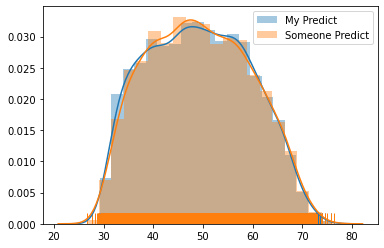

(0.9987424806898313, 0.0)


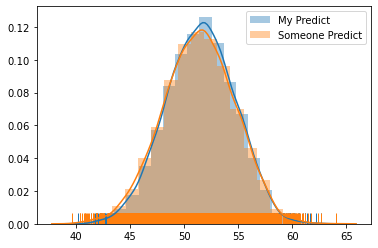

(0.9918851367502161, 0.0)


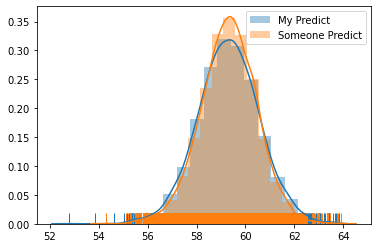

(0.9567312123202747, 0.0)


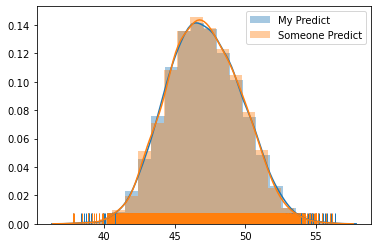

(0.9878654186145842, 0.0)


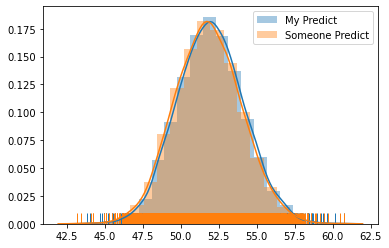

(0.9848755906750286, 0.0)


In [46]:
for my_each_pred, someone_each_pred in zip(someone_multilayer_df, someone_multilayer_only_or_df):
    plt.figure(figsize=(6,4))
    #     target_mean = target_array.mean()
    target_plot = sns.distplot(my_each_pred, kde=True, rug=True, bins=20, label='My Predict')
    target_plot = sns.distplot(someone_each_pred, kde=True, rug=True, bins=20, label='Someone Predict')
#     target_plot = sns.distplot(each_real, kde=True, rug=True, bins=20, label='Real')
#     max_height = max([obj.get_height() for obj in target_plot.get_children() if isinstance(obj, matplotlib.patches.Rectangle)]) 
#     plt.vlines(target_mean, 0, max_height, colors='grey', linestyles='dashed')
#     plt.xlim(0,100)
#     plt.title(each_str)
    plt.legend(loc='upper right')
    plt.show()
    print(pearsonr(my_each_pred, someone_each_pred))

In [106]:
someone_multilayer_only_or_df = pd.read_csv(pth.join(submission_base, 'Top_Public_selected_feature_thr_mean_only_or_devided_600.csv'))

In [107]:
id_array = someone_multilayer_only_or_df.values[:,0].reshape(5,-1).T
id_array[:3]

array([['10003_age', '10003_domain1_var1', '10003_domain1_var2',
        '10003_domain2_var1', '10003_domain2_var2'],
       ['10006_age', '10006_domain1_var1', '10006_domain1_var2',
        '10006_domain2_var1', '10006_domain2_var2'],
       ['10010_age', '10010_domain1_var1', '10010_domain1_var2',
        '10010_domain2_var1', '10010_domain2_var2']], dtype=object)

In [108]:
someone_multilayer_only_or_df = someone_multilayer_only_or_df.values[:,1].reshape(5,-1).T
someone_multilayer_only_or_df.shape

(5877, 5)

In [109]:
train_mean_array = y.mean(axis=0)

In [110]:
merged_mean_array = someone_multilayer_only_or_df.mean(axis=0)
residual_array = train_mean_array - merged_mean_array
residual_array[1] += 1
residual_array[4] += 2
print(residual_array)

age              0.680268
domain1_var1      1.14047
domain1_var2   -0.0639754
domain2_var1     0.266225
domain2_var2      2.09598
dtype: object


In [111]:
filename = 'Top_Public_selected_feature_thr_mean_only_or_devided_600'

with open(pth.join(submission_base, '{}_residual_1th_1_4th_+2.csv'.format(filename)), 'w') as f:
# with open(pth.join(submission_base, '{}_pred_my-0.4_someone-0.6.csv'.format(filename)), 'w') as f:
    f.write('Id,Predicted\n')
    for each_targets, each_merged_array in tqdm(zip(id_array, someone_multilayer_only_or_df), total=len(id_array)):
        each_merged_array += residual_array
        for each_label, each_value in zip(each_targets, each_merged_array):
            f.write('{},{}\n'.format(each_label, each_value))